# Logistic Regression Baseline Model Development
The purpose of this notebook is to explore preprocessing techniques beyond the simple data cleaning formalized in the notebook "EDA" (!!!hyperlink this!!!). 

My main goal is to discover the best sampling method to address the class imbalance present in the target variable.

I will also prototype various hyper parameter settings. 

## Load and clean data

In [1]:
from preprocessor import data_cleaner

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score,cross_val_predict


In [2]:
# import and define training data. See preprocessor.py file for details on data_cleaner()
X_train, y_train = data_cleaner("../data/train.csv.zip")

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Age                                103904 non-null  int64  
 1   Flight Distance                    103904 non-null  int64  
 2   Inflight wifi service              103904 non-null  int64  
 3   Departure/Arrival time convenient  103904 non-null  int64  
 4   Ease of Online booking             103904 non-null  int64  
 5   Gate location                      103904 non-null  int64  
 6   Food and drink                     103904 non-null  int64  
 7   Online boarding                    103904 non-null  int64  
 8   Seat comfort                       103904 non-null  int64  
 9   Inflight entertainment             103904 non-null  int64  
 10  On-board service                   103904 non-null  int64  
 11  Leg room service                   1039

## Develop baseline model

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.metrics import plot_confusion_matrix,confusion_matrix,classification_report, roc_curve,auc

### fit estimator

In [5]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train,y_train)

y_train_pred = cross_val_predict(logreg,X_train,y_train)

train_score = cross_val_score(logreg,X_train,y_train_pred,scoring='f1')

In [6]:
train_score.mean()

0.9848444640204921

### print classification report

In [7]:
baseline_report = classification_report(y_train,y_train_pred,output_dict=True)
baseline_report = pd.DataFrame(baseline_report).iloc[:,0:3]
baseline_report

,0,1,accuracy
precision,0.932692,0.765552,0.905076
recall,0.952604,0.692429,0.905076
f1-score,0.942543,0.727157,0.905076
support,84923.000000,18981.000000,0.905076


### plot confusion matrix

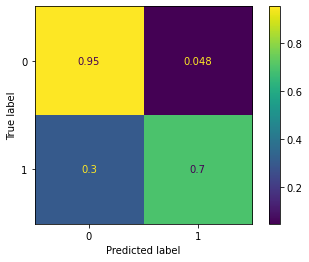

In [8]:
plot_confusion_matrix(logreg,X_train,y_train,normalize='true')
plt.show()

In [9]:
# Calculate the probability scores of each point in the training set
y_train_score = logreg.decision_function(X_train)

# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

In [10]:
baseline_auc = auc(train_fpr, train_tpr)

### calculate ROC AUC and plot curve

Training AUC: 0.9471988366981169


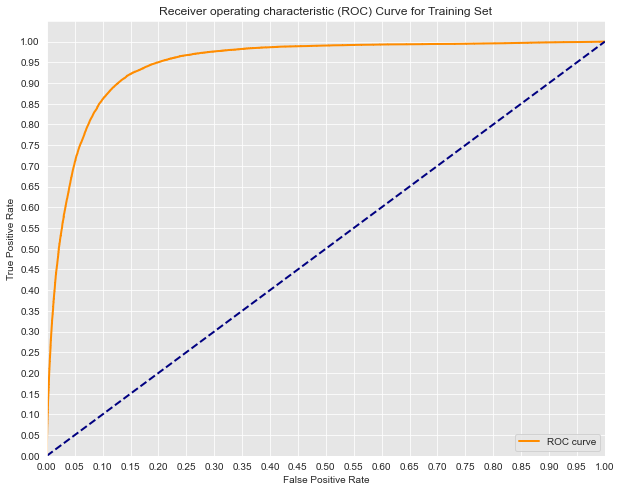

In [11]:
# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# ROC curve for training set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')
print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))
plt.show()

## Prototype sampling methods
- SMOTE (synthetic over sampling)
- Tomek Links (under sampling against decision boundary)
- Near Miss (distance based under sampling)
- Edited Nearest Neighbors (under samplin against decision boundary)
- SMOTETomek (SMOTE/Tomek Link ensemble)
- SMOETENN (SMOTE/Edited Nearest Neighbors Ensemble)

### SMOTE

##### resample data

In [12]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print('Original dataset weights:', y_train.value_counts(normalize=True))
print('Original dataset size:',len(y_train))
print('\nResample dataset weights', y_smote.value_counts(normalize=True))
print('Resample dataset size:', len(y_smote))

Original dataset weights: 0    0.817322
1    0.182678
Name: disloyal Customer, dtype: float64
Original dataset size: 103904

Resample dataset weights 1    0.5
0    0.5
Name: disloyal Customer, dtype: float64
Resample dataset size: 169846


#### fit estimator

In [13]:
logreg_smote = LogisticRegression(solver='liblinear')
logreg_smote.fit(X_smote,y_smote)

smote_train_pred = logreg_smote.predict(X_smote)

smote_train_score = cross_val_score(logreg_smote,X_smote,smote_train_pred,scoring='f1',n_jobs=3)
print(smote_train_score.mean())

0.993825113914695


#### plot confusion matrix

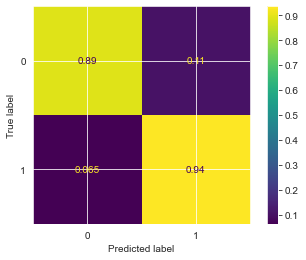

In [14]:
plot_confusion_matrix(logreg_smote,X_smote,y_smote,normalize='true')
plt.show()

#### print classification report

In [15]:
smote_report = classification_report(y_smote,smote_train_pred,output_dict=True)
smote_report = pd.DataFrame(smote_report).iloc[:,0:3]
smote_report

,0,1,accuracy
precision,0.932420,0.896163,0.913498
recall,0.891619,0.935377,0.913498
f1-score,0.911563,0.915350,0.913498
support,84923.000000,84923.000000,0.913498


#### calculate ROC AUC

In [16]:
# Calculate the probability scores of each point in the training set
y_smote_score = logreg_smote.decision_function(X_smote)
# Calculate the fpr, tpr, and thresholds for the training set
smote_fpr, smote_tpr, smote_thresholds = roc_curve(y_smote, y_smote_score)
smote_auc = auc(smote_fpr, smote_tpr)
print('Training AUC: {}'.format(smote_auc))

Training AUC: 0.9645822106754068


### Tomek Links

#### resample data

In [17]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks(sampling_strategy='majority',n_jobs=3)
X_tl, y_tl = tl.fit_resample(X_train, y_train)

print('Original dataset weights:', y_train.value_counts(normalize=True))
print('Original dataset size:',len(y_train))
print('\nResample dataset weights', y_tl.value_counts(normalize=True))
print('Resample dataset size:', len(y_tl))

Original dataset weights: 0    0.817322
1    0.182678
Name: disloyal Customer, dtype: float64
Original dataset size: 103904

Resample dataset weights 0    0.809029
1    0.190971
Name: disloyal Customer, dtype: float64
Resample dataset size: 99392


#### fit estimator

In [18]:
logreg_tl = LogisticRegression(solver='liblinear')
logreg_tl.fit(X_tl,y_tl)

tl_train_pred = logreg_tl.predict(X_tl)

tl_train_score = cross_val_score(logreg_tl,X_tl,y_tl,n_jobs=3,scoring='f1')
print(tl_train_score.mean())

0.7469474086997104


#### plot confusion matrix

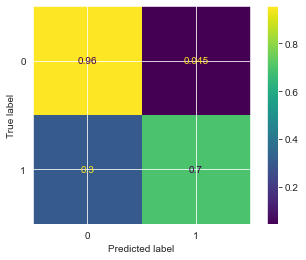

In [19]:
plot_confusion_matrix(logreg_tl,X_tl,y_tl,normalize='true')
plt.show()

#### print classification report

In [20]:
tomek_report = classification_report(y_tl,tl_train_pred,output_dict=True)
tomek_report = pd.DataFrame(tomek_report).iloc[:,0:3]
tomek_report

,0,1,accuracy
precision,0.930535,0.785719,0.905968
recall,0.955068,0.697961,0.905968
f1-score,0.942642,0.739244,0.905968
support,80411.000000,18981.000000,0.905968


#### calculate ROC AUC

In [21]:
# Calculate the probability scores of each point in the training set
y_tomek_score = logreg_smote.decision_function(X_tl)
# Calculate the fpr, tpr, and thresholds for the training set
tl_fpr , tl_tpr, tomek_thresholds = roc_curve(y_tl, y_tomek_score)
tl_auc = auc(tl_fpr, tl_tpr)
print('Training AUC: {}'.format(tl_auc))

Training AUC: 0.9434908347763292


### Near Miss

#### resample the data

In [22]:
from imblearn.under_sampling import NearMiss
nm = NearMiss(sampling_strategy='all',n_jobs=3)
X_nm, y_nm = nm.fit_resample(X_train,y_train)

print('Original dataset weights:', y_train.value_counts(normalize=True))
print('Original dataset size:',len(y_train))
print('\nResample dataset weights', y_nm.value_counts(normalize=True))
print('Resample dataset size:', len(y_nm))

Original dataset weights: 0    0.817322
1    0.182678
Name: disloyal Customer, dtype: float64
Original dataset size: 103904

Resample dataset weights 1    0.5
0    0.5
Name: disloyal Customer, dtype: float64
Resample dataset size: 37962


#### fit estimator

In [23]:
logreg_nm = LogisticRegression(solver='liblinear')
logreg_nm.fit(X_nm,y_nm)

nm_train_pred = logreg_nm.predict(X_nm)

nm_train_score = cross_val_score(logreg_nm,X_nm,y_nm,n_jobs=3,scoring='f1')
print(nm_train_score.mean())

0.8708729312696878


#### plot confusion matrix

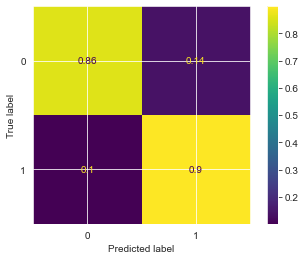

In [24]:
plot_confusion_matrix(logreg_nm,X_nm,y_nm,normalize='true')
plt.show()

#### print classification report

In [25]:
nm_report = classification_report(y_nm,nm_train_pred,output_dict=True)
nm_report = pd.DataFrame(nm_report).iloc[:,0:3]
nm_report

,0,1,accuracy
precision,0.894884,0.865828,0.879801
recall,0.860703,0.898899,0.879801
f1-score,0.877461,0.882053,0.879801
support,18981.000000,18981.000000,0.879801


#### calculate ROC AUC

In [26]:
# Calculate the probability scores of each point in the training set
y_nm_score  = logreg_nm.decision_function(X_nm)
# Calculate the fpr, tpr, and thresholds for the training set
nm_fpr , nm_tpr, nm_thresholds = roc_curve(y_nm, y_nm_score )
nm_auc = auc(nm_fpr, nm_tpr)
print('Training AUC: {}'.format(nm_auc))

Training AUC: 0.9499421309957607


### Edited Nearest Neighbors

#### resample the data

In [27]:
from imblearn.under_sampling import EditedNearestNeighbours
ENN = EditedNearestNeighbours(sampling_strategy='majority')
X_enn, y_enn = ENN.fit_resample(X_train,y_train)

print('Original dataset weights:', y_train.value_counts(normalize=True))
print('Original dataset size:',len(y_train))
print('\nResample dataset weights', y_enn.value_counts(normalize=True))
print('Resample dataset size:', len(y_enn))

Original dataset weights: 0    0.817322
1    0.182678
Name: disloyal Customer, dtype: float64
Original dataset size: 103904

Resample dataset weights 0    0.760619
1    0.239381
Name: disloyal Customer, dtype: float64
Resample dataset size: 79292


#### fit estimator

In [28]:
logreg_ENN = LogisticRegression(solver='liblinear')
logreg_ENN.fit(X_enn,y_enn)

enn_train_pred = cross_val_predict(logreg_ENN,X_enn,y_enn,n_jobs=3)

enn_train_score = cross_val_score(logreg_ENN,X_enn,y_enn,n_jobs=3,scoring='f1')
print(enn_train_score.mean())

0.8329351715136429


#### plot confusion matrix

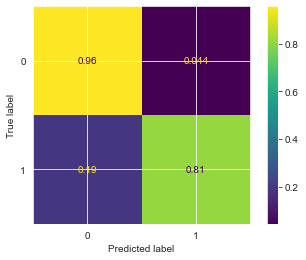

In [29]:
plot_confusion_matrix(logreg_ENN,X_enn,y_enn,normalize='true')
plt.show()

#### print classification matrix

In [30]:
enn_report = classification_report(y_enn,enn_train_pred,output_dict=True)
enn_report = pd.DataFrame(enn_report).iloc[:,0:3]
enn_report

,0,1,accuracy
precision,0.942915,0.850206,0.921606
recall,0.954735,0.816343,0.921606
f1-score,0.948788,0.832930,0.921606
support,60311.000000,18981.000000,0.921606


#### calculate ROC AUC

In [31]:
# Calculate the probability scores of each point in the training set
y_enn_score  = logreg_nm.decision_function(X_enn)
# Calculate the fpr, tpr, and thresholds for the training set
enn_fpr , enn_tpr, enn_thresholds = roc_curve(y_enn, y_enn_score )
enn_auc = auc(enn_fpr, enn_tpr)
print('Training AUC: {}'.format(enn_auc))

Training AUC: 0.7817683396992051


### SMOTETomek

#### resample the data

In [32]:
from imblearn.combine import SMOTETomek
SMOTek = SMOTETomek(sampling_strategy='all',smote=smote,tomek=tl,n_jobs=3)
X_smotek, y_smotek = SMOTek.fit_resample(X_train,y_train)

print('Original dataset weights:', y_train.value_counts(normalize=True))
print('Original dataset size:',len(y_train))
print('\nResample dataset weights', y_smotek.value_counts(normalize=True))
print('Resample dataset size:', len(y_smotek))

Original dataset weights: 0    0.817322
1    0.182678
Name: disloyal Customer, dtype: float64
Original dataset size: 103904

Resample dataset weights 1    0.501423
0    0.498577
Name: disloyal Customer, dtype: float64
Resample dataset size: 169364


#### fit estimator

In [33]:
logreg_SMOTek = LogisticRegression(solver='liblinear')
logreg_SMOTek.fit(X_smotek,y_smotek)

smotek_train_pred = logreg_SMOTek.predict(X_smotek)

smotek_train_score = cross_val_score(logreg_SMOTek,X_smotek,y_smotek,n_jobs=3,scoring='f1')
print(smotek_train_score.mean())

0.9092644474215696


#### plot confusion matrix

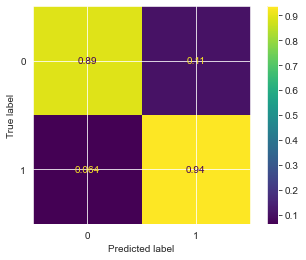

In [34]:
plot_confusion_matrix(logreg_SMOTek,X_smotek,y_smotek,normalize='true')
plt.show()

#### print classification report

In [35]:
smotek_report = classification_report(y_nm,nm_train_pred,output_dict=True)
smotek_report = pd.DataFrame(smotek_report).iloc[:,0:3]
smotek_report

,0,1,accuracy
precision,0.894884,0.865828,0.879801
recall,0.860703,0.898899,0.879801
f1-score,0.877461,0.882053,0.879801
support,18981.000000,18981.000000,0.879801


#### calculate ROC AUC

In [36]:
# Calculate the probability scores of each point in the training set
y_smotek_score  = logreg_SMOTek.decision_function(X_smotek)
# Calculate the fpr, tpr, and thresholds for the training set
smotek_fpr , smotek_tpr, smotek_thresholds = roc_curve(y_smotek, y_smotek_score )
smotek_auc = auc(smotek_fpr, smotek_tpr)
print('Training AUC: {}'.format(smotek_auc))

Training AUC: 0.9647099965956508


### SMOTENN

#### resmaple the data

In [37]:
from imblearn.combine import SMOTEENN
SMN = SMOTEENN(sampling_strategy='all',smote=smote,enn=ENN,n_jobs=3)
X_smn, y_smn = SMN.fit_resample(X_train,y_train)

print('Original dataset weights:', y_train.value_counts(normalize=True))
print('Original dataset size:',len(y_train))
print('\nResample dataset weights', y_smn.value_counts(normalize=True))
print('Resample dataset size:', len(y_smn))

Original dataset weights: 0    0.817322
1    0.182678
Name: disloyal Customer, dtype: float64
Original dataset size: 103904

Resample dataset weights 1    0.618792
0    0.381208
Name: disloyal Customer, dtype: float64
Resample dataset size: 137240


#### fit estimator

In [38]:
logreg_SMOTENN = LogisticRegression(solver='liblinear')
logreg_SMOTENN.fit(X_smn,y_smn)

smn_train_pred = logreg_SMOTENN.predict(X_smn)

smn_train_score = cross_val_score(logreg_SMOTENN,X_smn,y_smn,n_jobs=3,scoring='f1')
print(smn_train_score.mean())

0.9504230038099541


#### plot confusion matrix

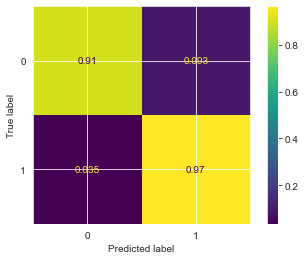

In [39]:
plot_confusion_matrix(logreg_SMOTENN,X_smn,y_smn,normalize='true')
plt.show()

#### print classification report

In [40]:
SMOTENN_report = classification_report(y_smn,smn_train_pred,output_dict=True)
SMOTENN_report = pd.DataFrame(SMOTENN_report).iloc[:,0:3]
SMOTENN_report

,0,1,accuracy
precision,0.941517,0.943891,0.94302
recall,0.906856,0.965298,0.94302
f1-score,0.923862,0.954475,0.94302
support,52317.000000,84923.000000,0.94302


#### calculate ROC AUC

In [41]:
# Calculate the probability scores of each point in the training set
SMOTENN_score  = logreg_SMOTENN.decision_function(X_smn)
# Calculate the fpr, tpr, and thresholds for the training set
smotenn_fpr , smotenn_tpr, smotenn_thresholds = roc_curve(y_smn, SMOTENN_score)
smotenn_auc = auc(smotenn_fpr, smotenn_tpr)
print('Training AUC: {}'.format(smotenn_auc))

Training AUC: 0.9810652094683898


## Validate sample and select method(s)
- First tried SMOTENN because it had the highest F1, validation however had a ROC AUC of about .06, indicating the model is overfitting the data. 
- Next I am trying Near Miss because it only undersamples the majority and had a training F1 score between SMOTE and Edited Nearest Neighbors, the two methods used in SMOTENN. Not synthesizing new data, and only undersampling I expect will reduce overfitting. 

In [42]:
# load and clean validation set
X_test, y_test = data_cleaner("../data/train.csv.zip")

### SMOTENN CV Test

#### fit cross validated model

In [43]:
logreg_SMOTENN_CV = LogisticRegressionCV(solver='liblinear',n_jobs=3)
logreg_SMOTENN_CV.fit(X_smn,y_smn)

LogisticRegressionCV(n_jobs=3, solver='liblinear')

In [44]:
smn_test_pred = logreg_SMOTENN_CV.predict(X_test)
smn_test_report = classification_report(y_test,smn_test_pred,output_dict=True)
SMOTENN_CV_report = pd.DataFrame(smn_test_report).iloc[:,0:3]
SMOTENN_CV_report

,0,1,accuracy
precision,0.978902,0.577867,0.862517
recall,0.850111,0.918023,0.862517
f1-score,0.909972,0.709270,0.862517
support,84923.000000,18981.000000,0.862517


#### plot confusion matrix

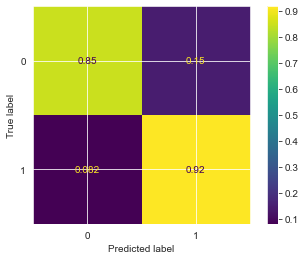

In [45]:
# plot confusion matrix
plot_confusion_matrix(logreg_SMOTENN_CV,X_test,y_test,normalize='true')
plt.show()

#### plot ROC AUC

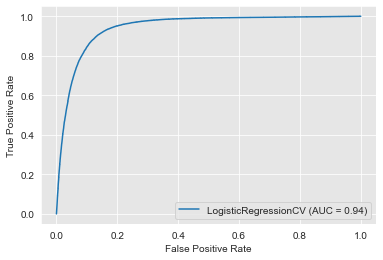

In [46]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(logreg_SMOTENN_CV,X_test,y_test)
plt.show()

In [47]:
# Calculate the probability scores of each point in the training set
SMOTENN_CV_score  = logreg_SMOTENN_CV.decision_function(X_test)
# Calculate the fpr, tpr, and thresholds for the training set
smotenn_cv_fpr , smotenn_cv_tpr, smotenn_cv_thresholds = roc_curve(y_test, SMOTENN_CV_score)
smotenn_cv_auc = auc(smotenn_cv_fpr, smotenn_cv_tpr)
print('SMOTENN Test AUC: {}'.format(smotenn_cv_auc))

SMOTENN Test AUC: 0.9419915299042956


### Near Miss CV Test

#### fit cross validated model

In [48]:
logreg_nm_cv = LogisticRegressionCV(solver='liblinear',n_jobs=3)
logreg_nm_cv.fit(X_nm,y_nm)

nm_test_pred = logreg_nm_cv.predict(X_test)
nm_test_report = classification_report(y_test,nm_test_pred,output_dict=True)
nm_test_report = pd.DataFrame(nm_test_report).iloc[:,0:3]
nm_test_report

,0,1,accuracy
precision,0.965475,0.354056,0.681985
recall,0.633562,0.898635,0.681985
f1-score,0.765071,0.507974,0.681985
support,84923.000000,18981.000000,0.681985


#### plot confusion matrix

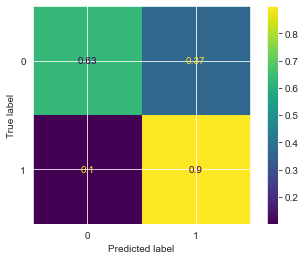

In [49]:
plot_confusion_matrix(logreg_nm_cv,X_test,y_test,normalize='true')
plt.show()

#### plot ROC AUC

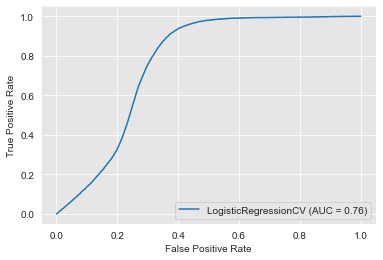

In [50]:
plot_roc_curve(logreg_nm_cv,X_test,y_test)
plt.show()

In [51]:
# Calculate the probability scores of each point in the training set
nm_cv_score  = logreg_nm_cv.decision_function(X_test)
# Calculate the fpr, tpr, and thresholds for the training set
nm_cv_fpr , nm_cv_tpr, nm_cv_thresholds = roc_curve(y_test, nm_cv_score)
nm_cv_auc = auc(nm_cv_fpr, nm_cv_tpr)
print('Near Miss Test AUC: {}'.format(nm_cv_auc))

Near Miss Test AUC: 0.7630068283211038


## Visualize F1, ROC AUC iterative performance

In [52]:
f1_scores = [
    baseline_report.iloc[2,1],
    smote_report.iloc[2,1],
    tomek_report.iloc[2,1],
    nm_report.iloc[2,1],
    enn_report.iloc[2,1],
    smotek_report.iloc[2,1],
    SMOTENN_report.iloc[2,1],
    SMOTENN_CV_report.iloc[2,1],
    nm_test_report.iloc[2,1]
]
np.mean(f1_scores)

0.7945008205358247

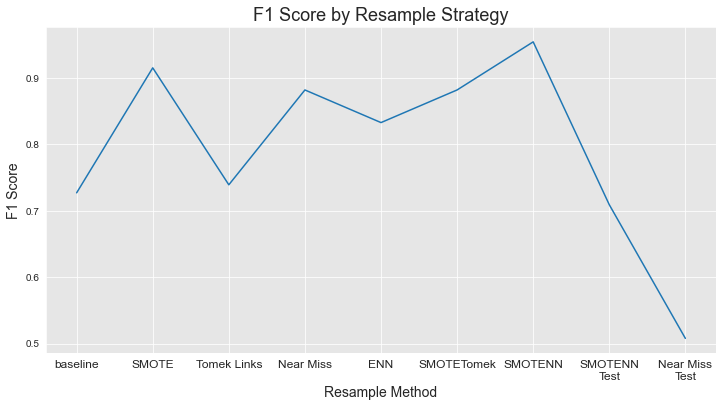

In [59]:
plt.figure(figsize=(12,6))
x = ['baseline','SMOTE','Tomek Links','Near Miss','ENN','SMOTETomek','SMOTENN','SMOTENN\nTest','Near Miss\nTest']
y = f1_scores
plt.plot(x,y)
plt.ylabel('F1 Score',fontsize=14)
plt.xlabel('Resample Method',fontsize=14)
plt.xticks(fontsize=12)
plt.title("F1 Score by Resample Strategy",fontsize=18)
plt.show()

In [60]:
roc_auc_scores = [
    baseline_auc,
    smote_auc,
    tl_auc,
    nm_auc,
    enn_auc,
    smotek_auc,
    smotenn_auc,
    smotenn_cv_auc,
    nm_cv_auc
]
np.mean(roc_auc_scores)

0.9153062130149175

#### plot ROC AUC curves

Baseline Model AUC: 0.9471988366981169
SMOTE resample AUC: 0.9645822106754068
Tomek Links AUC: 0.9434908347763292
Near Miss AUC: 0.9499421309957607
Edited Nearest Neighbors AUC: 0.7817683396992051
SMOTETomek AUC: 0.9647099965956508
SMOTEENN AUC: 0.9810652094683898


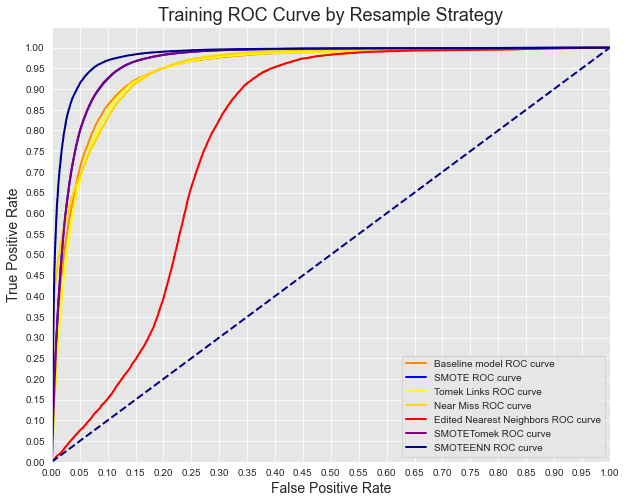

In [69]:
plt.figure(figsize=(10,8))
lw = 2

print('Baseline Model AUC: {}'.format(baseline_auc))
print('SMOTE resample AUC: {}'.format(smote_auc))

plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='Baseline model ROC curve')
plt.plot(smote_fpr, smote_tpr, color='blue',
         lw=lw, label='SMOTE ROC curve')


print('Tomek Links AUC: {}'.format(tl_auc))
print('Near Miss AUC: {}'.format(nm_auc))

plt.plot(tl_fpr, tl_tpr, color='yellow',
         lw=lw, label='Tomek Links ROC curve')
plt.plot(nm_fpr, nm_tpr, color='gold',
         lw=lw, label='Near Miss ROC curve')


print('Edited Nearest Neighbors AUC: {}'.format(enn_auc))
print('SMOTETomek AUC: {}'.format(smotek_auc))

plt.plot(enn_fpr, enn_tpr, color='red',
         lw=lw, label='Edited Nearest Neighbors ROC curve')
plt.plot(smotek_fpr, smotek_tpr, color='purple',
         lw=lw, label='SMOTETomek ROC curve')


print('SMOTEENN AUC: {}'.format(smotenn_auc))
plt.plot(smotenn_fpr, smotenn_tpr, color='darkblue',
         lw=lw, label='SMOTEENN ROC curve')


# Formatting
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('Training ROC Curve by Resample Strategy',fontsize=18)
plt.legend(loc="lower right")
plt.show()

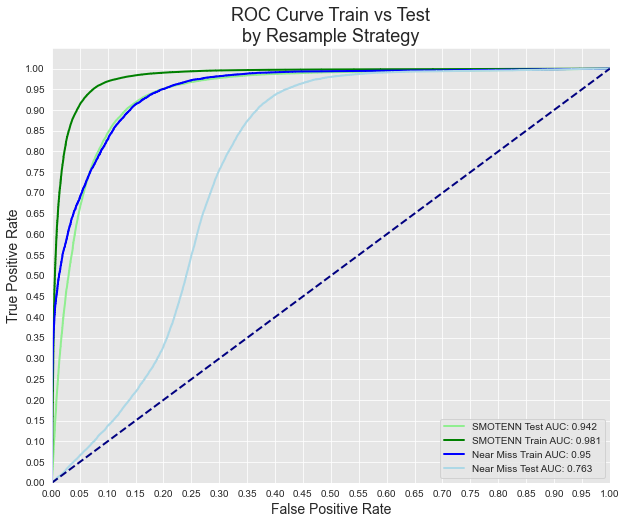

In [73]:
plt.figure(figsize=(10,8))
lw = 2

plt.plot(smotenn_cv_fpr, smotenn_cv_tpr, color='lightgreen',
         lw=lw, label=f'SMOTENN Test AUC: {round(smotenn_cv_auc,3)}')
plt.plot(smotenn_fpr,smotenn_tpr,color='green',
         lw=lw, label=f'SMOTENN Train AUC: {round(smotenn_auc,3)}')

plt.plot(nm_fpr, nm_tpr, color='blue',
         lw=lw, label=f'Near Miss Train AUC: {round(nm_auc,3)}')
plt.plot(nm_cv_fpr, nm_cv_tpr, color='lightblue',
         lw=lw, label=f'Near Miss Test AUC: {round(nm_cv_auc,3)}')

# Formatting
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('ROC Curve Train vs Test\nby Resample Strategy',fontsize=18)
plt.legend(loc="lower right")
plt.show()

## Final Observations

The ensemble of oversampling with SMOTE and undersampling with Edited Nearest Neighbors is clearly the strongest performer among the resampling methods explored in this notebook, mainly based on F1 score and ROC AUC. I bothered to also test Near Miss, because it is the best performing non-ensemble method and it only undersamples (there is no data used that didn't exist in the first place); I won't be moving forward with Near Miss because it under-performed against SMOTEENN consistently with the training models.

The next step is to write a function in preprocessor.py to make this exact resample strategy portable between notebooks. 

In the next development notebook I will use the preprocessing from EDA, and the SMOTEENN resampling method found here to train and optimize via gridsearching a decision tree and/or random forest. To use as my final model.